In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sns
from pathlib import Path 
import warnings
warnings.filterwarnings("ignore")
import pyreadr
import random
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('Cleaned_NGSIM_Data3.csv')

In [3]:
df

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Class,v_Vel,...,Vehicle_combination,preceding_vehicle_length,lane_changes,Prec_Vehicle_ID,previous_Vehicle_Velocity,previous_Vehicle_Acceleration,previous_car_lane_changes,previous_Local_Y,pair_Time_Duration,total_pair_duration
0,1099,2680,1118847246900,4.164,29.837,6451143.087,1873357.308,3.50520,2,11.500104,...,Car-Car,4.77520,False,1093,8.763000,-2.904744,False,103.266,0.0,149.7
1,1099,2681,1118847247000,4.144,33.837,6451145.775,1873354.346,3.50520,2,11.500104,...,Car-Car,4.77520,False,1093,8.525256,-2.292096,False,106.083,0.1,149.7
2,1099,2682,1118847247100,4.123,37.837,6451148.464,1873351.385,3.50520,2,11.500104,...,Car-Car,4.77520,False,1093,8.421624,0.000000,False,108.794,0.2,149.7
3,1099,2683,1118847247200,4.103,41.836,6451151.152,1873348.423,3.50520,2,11.500104,...,Car-Car,4.77520,False,1093,8.528304,2.365248,False,111.504,0.3,149.7
4,1099,2684,1118847247300,4.085,45.337,6451153.505,1873345.831,3.50520,2,11.500104,...,Car-Car,4.77520,False,1093,8.772144,2.941320,False,114.324,0.4,149.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433194,2477,10503,1113438615200,5.725,1572.720,6042618.329,2134626.205,5.88264,2,9.293352,...,Car-Car,5.60832,False,2472,9.954768,2.139696,False,1629.271,38.0,38.4
433195,2477,10504,1113438615300,5.868,1575.604,6042618.026,2134628.992,5.88264,2,8.186928,...,Car-Car,5.60832,False,2472,10.049256,-0.356616,False,1632.622,38.1,38.4
433196,2477,10505,1113438615400,5.971,1578.231,6042617.741,2134631.418,5.88264,2,7.534656,...,Car-Car,5.60832,False,2472,10.049256,0.000000,False,1636.040,38.2,38.4
433197,2477,10506,1113438615500,5.992,1580.512,6042617.433,2134633.468,5.88264,2,7.555992,...,Car-Car,5.60832,False,2472,10.049256,0.000000,False,1639.040,38.3,38.4


In [4]:
df["nextframeAcc"]=df.groupby(["L-F_Pair"],as_index=False)["v_Acc"].shift(-1)
df["nextframesvel"]=df.groupby(["L-F_Pair"],as_index=False)["v_Vel"].shift(-1)
df["nextframeposition"]=df.groupby(["L-F_Pair"],as_index=False)["Local_Y"].shift(-1)

In [5]:
df['Pair_Time_Duration']=(df.groupby(['L-F_Pair'],as_index=False).cumcount()*0.1) +0.1

In [6]:
df['PrecVehType'] = df['Preceding_Vehicle_Class'].map({'Motorcycle': 1, 'Car': 2, 'Heavy Vehicle': 3, 'Free Flow':4})


In [7]:
df['Vehicle.type'] = df['v_Class']

In [8]:
df = df[df["Preceding_Vehicle_Class"].notna()]

df = df[df["v_Vel"].notna()]

df = df[df["Rear_to_Front_Space_Headway"].notna()]

df = df[df["Local_Y"].notna()]

df = df[df["nextframeAcc"].notna()]

df = df[df["Pair_Time_Duration"].notna()]

df = df[df["nextframeposition"].notna()]

df = df[df["nextframesvel"].notna()]

df = df[df["PrecVehType"].notna()]

df = df[df["Vehicle.type"].notna()]


In [9]:
def training_pairs(data):
    random.seed(2109)
    pairs = data["L-F_Pair"].unique()
    pairs = pairs.tolist()
    v = round(len(pairs)*0.7)   
    pairs = random.sample(pairs, v)
    return pairs
my_pairs=training_pairs(df)
#converting the total dataset to 70/30% pair for train and test. 
train = df[df['L-F_Pair'].isin(my_pairs)]

test = df[~df['L-F_Pair'].isin(my_pairs)]

In [23]:
len(train["L-F_Pair"].unique())

424

In [24]:
len(test["L-F_Pair"].unique())

182

In [26]:
test["Vehicle_combination"].unique()

array(['Car-Car', 'Free Flow-Car', 'Car-Motorcycle', 'Heavy Vehicle-Car',
       'Heavy Vehicle-Heavy Vehicle', 'Heavy Vehicle-Motorcycle'],
      dtype=object)

In [30]:
test[test["Vehicle_combination"] == "Heavy Vehicle-Heavy Vehicle"]["L-F_Pair"].unique()

array(['2695-2717'], dtype=object)

In [ ]:
test[test["Vehicle_combination"] == "Heavy Vehicle-Car"]["L-F_Pair"].unique()

In [31]:
test[test["Vehicle_combination"] == "Heavy Vehicle-Heavy Vehicle"]

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Class,v_Vel,...,previous_car_lane_changes,previous_Local_Y,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Pair_Time_Duration,PrecVehType,Vehicle.type
331827,2717,8145,1113437581400,27.184,92.254,6042846.883,2133162.588,17.12976,3,2.407920,...,False,179.555,0.0,67.1,0.000000,2.407920,93.043,0.1,3,3
331883,2717,8146,1113437581500,27.204,93.043,6042846.806,2133163.374,17.12976,3,2.407920,...,False,180.054,0.1,67.1,0.000000,2.407920,93.834,0.2,3,3
331946,2717,8147,1113437581600,27.225,93.834,6042846.729,2133164.161,17.12976,3,2.407920,...,False,180.544,0.2,67.1,0.000000,2.407920,94.623,0.3,3,3
331999,2717,8148,1113437581700,27.244,94.623,6042846.651,2133164.947,17.12976,3,2.407920,...,False,181.031,0.3,67.1,0.000000,2.407920,95.414,0.4,3,3
332025,2717,8149,1113437581800,27.264,95.414,6042846.574,2133165.734,17.12976,3,2.407920,...,False,181.546,0.4,67.1,0.000000,2.407920,96.203,0.5,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403762,2717,9424,1113437709300,28.748,1509.344,6042651.229,2134567.029,17.12976,3,6.355080,...,False,1628.222,66.6,67.1,-1.490472,6.199632,1511.392,66.7,3,3
403780,2717,9425,1113437709400,28.742,1511.392,6042650.897,2134569.030,17.12976,3,6.199632,...,False,1630.734,66.7,67.1,-0.079248,6.123432,1513.371,66.8,3,3
403820,2717,9426,1113437709500,28.738,1513.371,6042650.575,2134570.974,17.12976,3,6.123432,...,False,1633.412,66.8,67.1,1.414272,6.187440,1515.345,66.9,3,3
403847,2717,9427,1113437709600,28.732,1515.345,6042650.252,2134572.918,17.12976,3,6.187440,...,False,1636.314,66.9,67.1,2.295144,6.367272,1517.378,67.0,3,3


In [32]:
test

,Vehicle_ID,Frame_ID,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Class,v_Vel,...,previous_car_lane_changes,previous_Local_Y,pair_Time_Duration,total_pair_duration,nextframeAcc,nextframesvel,nextframeposition,Pair_Time_Duration,PrecVehType,Vehicle.type
608,1984,5632,1118847542100,3.384,30.802,6451144.312,1873357.112,3.65760,2,11.948160,...,False,70.827,0.0,63.2,0.000000,11.948160,34.801,0.1,2,2
609,1984,5633,1118847542200,3.364,34.801,6451147.000,1873354.150,3.65760,2,11.948160,...,False,74.637,0.1,63.2,0.000000,11.948160,38.802,0.2,2,2
610,1984,5634,1118847542300,3.344,38.802,6451149.689,1873351.188,3.65760,2,11.948160,...,False,78.298,0.2,63.2,0.000000,11.948160,42.801,0.3,2,2
611,1984,5635,1118847542400,3.323,42.801,6451152.377,1873348.227,3.65760,2,11.948160,...,False,81.908,0.3,63.2,0.000000,11.948160,46.801,0.4,2,2
612,1984,5636,1118847542500,3.302,46.801,6451155.066,1873345.265,3.65760,2,11.948160,...,False,85.569,0.4,63.2,-1.621536,11.948160,50.762,0.5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433193,2477,10502,1113438615100,5.524,1569.490,6042618.646,2134622.958,5.88264,2,10.451592,...,False,1626.011,37.9,38.4,-3.413760,9.293352,1572.720,38.0,2,2
433194,2477,10503,1113438615200,5.725,1572.720,6042618.329,2134626.205,5.88264,2,9.293352,...,False,1629.271,38.0,38.4,-3.413760,8.186928,1575.604,38.1,2,2
433195,2477,10504,1113438615300,5.868,1575.604,6042618.026,2134628.992,5.88264,2,8.186928,...,False,1632.622,38.1,38.4,-3.413760,7.534656,1578.231,38.2,2,2
433196,2477,10505,1113438615400,5.971,1578.231,6042617.741,2134631.418,5.88264,2,7.534656,...,False,1636.040,38.2,38.4,3.413760,7.555992,1580.512,38.3,2,2


In [10]:
X_train = train[["Rear_to_Front_Space_Headway",'PrecVehType','Vehicle.type','Velocity Difference_Following-Preceding','v_Vel']]
y_train= train['nextframeAcc']
X_test = test[["Rear_to_Front_Space_Headway",'PrecVehType','Vehicle.type','Velocity Difference_Following-Preceding','v_Vel']]
y_test= test['nextframeAcc']
rf = RandomForestRegressor(n_estimators = 150,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=150, n_jobs=-1)

In [71]:
df.columns

Index(['Vehicle_ID', 'Frame_ID', 'Global_Time', 'Local_X', 'Local_Y',
       'Global_X', 'Global_Y', 'v_length', 'v_Class', 'v_Vel', 'v_Acc',
       'Lane_ID', 'Preceding', 'Space_Headway', 'Time_Headway', 'Location',
       'Preceding_Vehicle_Class', 'Rear_to_Front_Space_Headway',
       'Front_To_Rear_Time_Headway', 'Velocity Difference_Following-Preceding',
       'Acceleration Difference_Following-Preceding', 'L-F_Pair',
       'v_Class_Name', 'Relative_Time', 'Vehicle_combination',
       'preceding_vehicle_length', 'lane_changes', 'Prec_Vehicle_ID',
       'previous_Vehicle_Velocity', 'previous_Vehicle_Acceleration',
       'previous_car_lane_changes', 'previous_Local_Y', 'pair_Time_Duration',
       'total_pair_duration', 'PrecVehType', 'nextframeAcc', 'nextframesvel',
       'nextframeposition', 'Pair_Time_Duration', 'Vehicle.type'],
      dtype='object')

In [12]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['L-F_Pair'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['L-F_Pair']== i]
        vel=np.zeros(Q.shape[0])
        PrecVehType =  np.zeros(Q.shape[0])
        FollVehtype = np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])
        local_y_subject = np.zeros(Q.shape[0])
        local_y_preceding = np.zeros(Q.shape[0])
        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['v_Vel']
        PrecVehType[0]=Q.iloc[0]['PrecVehType']
        FollVehtype[0] = Q.iloc[0]['Vehicle.type']
        spacing[0] = Q.iloc[0]['Rear_to_Front_Space_Headway']
        local_y_subject[0]=Q.iloc[0]['Local_Y']
        local_y_preceding[0]=Q.iloc[0]['previous_Local_Y']
        length_previous_vehicle=Q.iloc[0]['preceding_vehicle_length']        
        dv[0] = Q.iloc[0]['Velocity Difference_Following-Preceding']   
        #pred_speed[0] = Q.iloc[0]['svel']
    #?? verify this     
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(1,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j-1]*0.8)
            dv[j] = vel[j] - Q.iloc[j]['previous_Vehicle_Velocity']
            s = ((vel[j-1]*0.8)+ (0.5*pred_acc[j-1]*pow(0.8,2)))
            local_y_subject[j]=  local_y_subject[j-1] + s
            local_y_preceding[j]=  Q.iloc[j-1]['previous_Local_Y']
            spacing[j]=local_y_preceding[j] - local_y_subject[j] - Q.iloc[j-1]['previous_Local_Y'] -length_previous_vehicle
            PrecVehType[j]= PrecVehType[j-1]
            FollVehtype[j]=FollVehtype[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc']=pred_acc
        Q['pvel']=vel

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [35]:
c, b = data_in_parts(test,156,159)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, b, target_variable, rf)

['2522-2527', '2695-2717', '2694-2702']


In [43]:
F1["v_Acc"]

331827    0.000000
331883    0.000000
331946    0.000000
331999    0.000000
332025    0.000000
            ...   
403762   -1.905000
403780   -1.490472
403820   -0.079248
403847    1.414272
403884    2.295144
Name: v_Acc, Length: 671, dtype: float64

In [44]:
F1["nextframeAcc"]

331827    0.000000
331883    0.000000
331946    0.000000
331999    0.000000
332025    0.000000
            ...   
403762   -1.490472
403780   -0.079248
403820    1.414272
403847    2.295144
403884    2.136648
Name: nextframeAcc, Length: 671, dtype: float64

In [37]:
F1 = F[F["L-F_Pair"] == "2695-2717"]

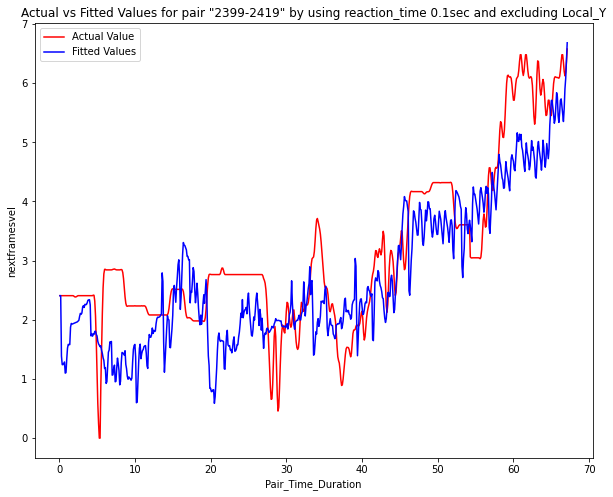

In [38]:
import seaborn as sns
plt.figure(figsize=(10, 8))


ax = sns.lineplot(x=F1["Pair_Time_Duration"], y = F1["nextframesvel"], color="r", label="Actual Value")
sns.lineplot(x=F1["Pair_Time_Duration"], y =F1["pvel"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values for pair "2399-2419" by using reaction_time 0.1sec and excluding Local_Y')


plt.show()
plt.close()

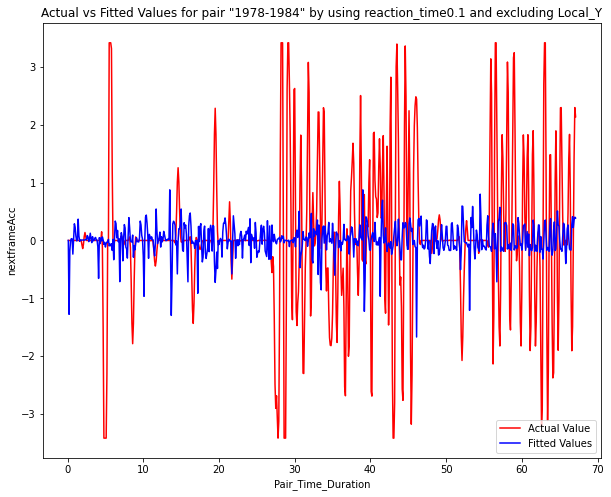

In [39]:
import seaborn as sns
plt.figure(figsize=(10, 8))


ax = sns.lineplot(x=F1["Pair_Time_Duration"], y = F1["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F1["Pair_Time_Duration"], y =F1["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values for pair "1978-1984" by using reaction_time0.1 and excluding Local_Y')


plt.show()
plt.close()

In [15]:
def accuracy(F):
    mae_score = mean_absolute_error(F['sacc'], F['pacc'])
    r2_scores = r2_score(F['sacc'], F['pacc'])
    return mae_score, r2_scores

In [16]:
accuracy(F)

(0.7591036202364712, -0.21580065453834663)

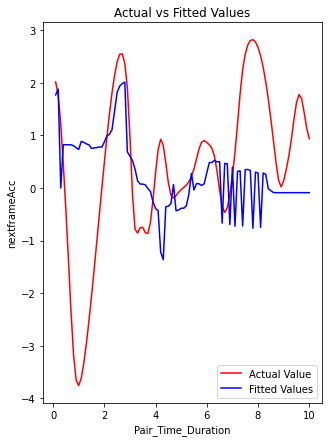

In [63]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.lineplot(x=F2["Pair_Time_Duration"], y = F2["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F2["Pair_Time_Duration"], y =F2["pacc"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [71]:
F0 = F[F["LF_pairs"] == "3355_1"]

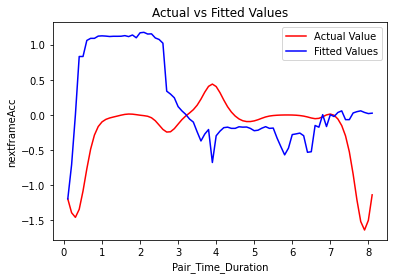

In [72]:
ax = sns.lineplot(x=F0["Pair_Time_Duration"], y = F0["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F0["Pair_Time_Duration"], y =F0["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [81]:
def data_in_parts(test,rangefrom,rangeto):
    a=test['LF_pairs'].unique()
    b = a.tolist()
    b = b[rangefrom:rangeto]
    c= len(a)/30
    return c,b 


def prediction(test,b,target_variable,RFReg):
    F_df = []
    r = []
    Q = pd.DataFrame()
# b is the test range
    for i in b:
# Q this is the input data frame
        Q = test[test['LF_pairs']== i]
        vel=np.zeros(Q.shape[0])
        PrecVehType =  np.zeros(Q.shape[0])
        FollVehtype = np.zeros(Q.shape[0])
        spacing = np.zeros(Q.shape[0])
        dv = np.zeros(Q.shape[0])
        pred_acc = np.zeros(Q.shape[0])
        
    
        #adding first value of the vehicle
        vel[0]=Q.iloc[0]['svel']
        PrecVehType[0]=Q.iloc[0]['PrecVehType']
        FollVehtype[0] = Q.iloc[0]['Vehicle.type']
        spacing[0] = Q.iloc[0]['spacing']
        
        dv[0] = Q.iloc[0]['dV']   
        #pred_speed[0] = Q.iloc[0]['svel']
    #?? verify this     
        pred_acc[0] = Q.iloc[1][target_variable]
     
    

#     #predicting first value of acceleration
            #check here
        pred_acc[1]= rf.predict(np.array([vel[0],PrecVehType[0],FollVehtype[0],dv[0],spacing[0]]).reshape(1,-1))
            

#     #calculating vel,frspacing,local.y,dv from the predicted acceleration.
            #check here
    
    
        for j in range(2,len(Q)):
#         ########
#         #print(j)
#         ########
            vel[j] = vel[j-1]+(pred_acc[j]*0.1)
            dv[j] = vel[j] - Q.iloc[j]['PrecVehVel']
            spacing[j] = ((vel[j-1]*0.1)+ (0.5*pred_acc[j]*pow(0.1,2))) ############################################################
            PrecVehType[j]= PrecVehType[j-1]
            FollVehtype[j]=FollVehtype[j-1]
#         ########
#         ## localy: s = ut + 0.5*a*t^2
#         ########
            
            if j == len(Q)-1:
                break
            pred_acc[j+1] = rf.predict(np.array([PrecVehType[j],FollVehtype[j],vel[j],dv[j],spacing[j]]).reshape(1, -1))
#         ########
#         #print(pred_acc)
#         ########
        Q['pacc1']=pred_acc

        F_df.append(Q)
        result = pd.concat(F_df)
        #r.append(r2_score(Q[target_variable], Q['pacc']))
        
 
    return result


In [87]:
c, b = data_in_parts(test,0,5)
print(b)


#Predicted acceleration
target_variable = 'nextframeAcc'
F = prediction(test, b, target_variable, rf)

['3355_1', '17_12', '15_13', '27_31', '25_39']


In [92]:
F["LF_pairs"].unique()

array(['3355_1', '17_12', '15_13', '27_31', '25_39'], dtype=object)

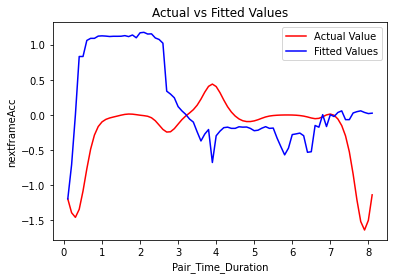

In [83]:
ax = sns.lineplot(x=F0["Pair_Time_Duration"], y = F0["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F0["Pair_Time_Duration"], y =F0["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()

In [93]:
F00 = F[F["LF_pairs"] == "15_13"]

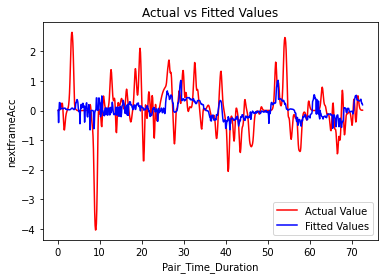

In [94]:
ax = sns.lineplot(x=F00["Pair_Time_Duration"], y = F00["nextframeAcc"], color="r", label="Actual Value")
sns.lineplot(x=F00["Pair_Time_Duration"], y =F00["pacc1"],  color="b", label="Fitted Values" )


plt.title('Actual vs Fitted Values')


plt.show()
plt.close()